# **Feature Selection**

**Feature selection** can be an important part of model selection. In supervised learning, including features in a model which do not provide information on the label is useless at best and may prevent generalization at worst.

Feature selection can involve application of several methods. Two important methods include:
1. Eliminating features with **low variance** and **zero variance**. Zero variance features are comprised of the same values. Low variance features arise from features with most values the same and with few unique values. One way low variance features can arise, is from dummy variables for categories with very few members. The dummy variable will be mostly 0s with very few 1s. 
2. Training machine learning models with features that are **uninformative** can create a variety of problems. An uninformative feature does not significantly improve model performance. In many cases, the noise in the uninformative features will increase the variance of the model predictions. In other words, uninformative models are likely to reduce the ability of the machine learning model to generalize.   

****
**Note:** the second case of feature selection involves applying a selection statistic or hypothesis test multiple times. For large number of features, this process is very likely to lead to false positive and false negative results. This likely outcome is known as the **multiple comparisons problem** in statistics.

To understand this problem, consider the decision to keep a feature in a model as a hypothesis test. Any hypothesis test has some probability of both a false positive result and a false negative result. Consider a case where there are 40 uninformative features which are excluded from the model with 95% confidence. There will be an approximately 5% chance of accepting a feature which should be rejected. In this case we would expect about 2 uninformative features to be accepted because of these errors. 

You may well ask, if testing features for importance can fail with large numbers of features, what is the alternative? The most general and scalable alternative is to use regularization methods. Consider applying regularization methods to a linear model. In this case, machine learning algorithm learns which features should be weighted highly and which should not. 
****

## **Getting started**

We will now apply the aforementioned principles to the Titanic data set. 

As a first step, run the code in the cell below to load the required packages. 

In [1]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Setting the path
import os
os.chdir("/content/drive/My Drive/Introduction to Data Science - Python edition/dataset/titanic")

In [0]:
# Loading libraries
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy.random as nr
import matplotlib.pyplot as plt
import math

%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
# load npy file
X_train = np.load('X_train.npy')
X_validation = np.load('X_validation.npy')
X_test = np.load('X_test.npy')

y_train = np.load('y_train.npy')
y_validation = np.load('y_validation.npy')
y_test = np.load('y_test.npy')

feature_name = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_Unknown']
print(feature_name)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_Unknown']


In [5]:
temp = pd.DataFrame(X_train)
temp.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00
mean,0.64,0.37,0.07,0.07,0.06,0.35,0.65,0.17,0.09,0.73,0.00
std,0.42,0.16,0.15,0.14,0.09,0.48,0.48,0.38,0.29,0.44,0.06
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.28,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,0.36,0.00,0.00,0.03,0.00,1.00,0.00,0.00,1.00,0.00
75%,1.00,0.45,0.12,0.00,0.06,1.00,1.00,0.00,0.00,1.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## **Eliminate low variance features**

As a fist step in selecting features from this dataset you will remove features with low variance. The `VarianceThreshold` function from the scikit-learn `feature_selection` package identifies features with less than some threshold of unique values. For a probability that a feature is unique $p$ the threshold is specified as;

$$Var(x) = p(1-p)$$

In this case a 80%, or $p=0.8$, threshold is used. 

The `fit_transform` method applies the threshold to the variance of each feature and removes features with variance below the threshold. The `get_support_` attribute shows the `True` and `False` logical for inclusion of each feature. 


In [6]:
from sklearn import feature_selection as fs
print(X_train.shape)

## Define the variance threhold and fit the threshold to the feature array. 
sel = fs.VarianceThreshold(threshold=(0.99 * (1 - 0.99)))
X_train_reduced = sel.fit_transform(X_train)
X_val_reduced = sel.transform(X_validation)
X_test_reduced = sel.transform(X_test)

## Print the support and shape for the transformed features
#print(sel.get_support())
print(X_train_reduced.shape)
selection_flag = sel.get_support()
feature_sel_summary = pd.DataFrame()
feature_sel_summary['Feature_name'] = feature_name
feature_sel_summary['selection_flag'] = selection_flag
feature_sel_summary

(623, 11)
(623, 9)


,Feature_name,selection_flag
0,Pclass,True
1,Age,True
2,SibSp,True
3,Parch,True
4,Fare,False
5,Sex_female,True
6,Sex_male,True
7,Embarked_C,True
8,Embarked_Q,True
9,Embarked_S,True


The number of features has been reduced from 11 to 9. Apparently, there are 2 low variance features in the original array.

## **Select k best features**

The low variance features have been eliminated. But, the question remains, are all these features informative? There are a number of methods used to determine the importance of features. Many machine learning models have specialized methods to determine feature importance specifically intended for those methods. 

In this example, we will use a fairly general and robust method using cross validation. The algorithm is straight forward. Features are recursively removed.  Cross validation is used to find the change in model performance, if any, to determine if a feature should be deleted altogether. 

The code in the cell below performs the following processing:

 1. Create the folds for the cross validation for feature selection. These folds should be independent of any other cross validation performed. 
 2. The logistic regression model is defined. 
 3. The `RFECV` function from the scikit-learn `feature_selection` package is used to determine which features to retain using a cross validation method. Notice that AUC is used as the model selection metric as the labels are imbalanced. In this case, the default, accuracy is a poor choice. 
 4. The RFECV feature selector is fit to the data. 

Execute this code and examine the results.

LogisticRegression(C=10, class_weight={0: 1, 1: 2.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Optimal number of features : 9


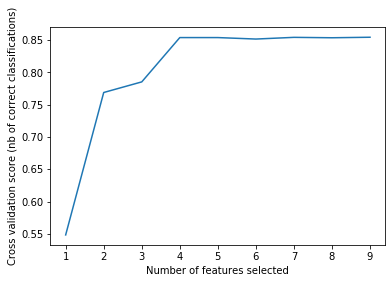

[1 1 1 1 1 1 1 1 1]


In [7]:
import sklearn.model_selection as ms
from sklearn import linear_model

## Set folds for nested cross validation
nr.seed(988)
feature_folds = ms.StratifiedKFold(n_splits=10, shuffle = True)

## Define the model
logistic_mod = linear_model.LogisticRegression(C = 10, class_weight = {0:1, 1:2.5}) 
print(logistic_mod)
## Perform feature selection by CV with high variance features only
nr.seed(6677)
rfecv = fs.RFECV(estimator=logistic_mod, step=1, cv=feature_folds, scoring='roc_auc')
rfecv = rfecv.fit(X_train_reduced, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print(rfecv.ranking_)

In [0]:
#from sklearn.feature_selection import RFE
#estimator = linear_model.LogisticRegression(C = 10, class_weight = {0:1, 1:2.5}) 

#selector = RFE(estimator, 4, step=1)
#selector = selector.fit(X_train_reduced, y_train)

#print(selector.ranking_)

Notice that the features which have been selected are shown with a rank of 1. The features eliminated are shown with higher numbers.

The code in the cell below as uses the `transform` method applies the selector to the feature array.

In [9]:
X_train_reduced = rfecv.transform(X_train_reduced)
X_val_reduced = rfecv.transform(X_val_reduced)
X_test_reduced = rfecv.transform(X_test_reduced)

print(X_train_reduced.shape)
print(X_val_reduced.shape)
print(X_test_reduced.shape)

(623, 9)
(134, 9)
(134, 9)


As we can see, there is no change in feature count.

Notice that the change in AUC is not that great across a range of features selected.

## **Apply nested cross validation to create model**

The next step is to use nested cross validation to optimize the model hyperparameter and test the model performance. The model is constructed using the features selected. 

As a first step, construct the inside and outside folds for the nested cross validation by running the code in the cell below. 

In [0]:
nr.seed(123)
inside = ms.StratifiedKFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.StratifiedKFold(n_splits=10, shuffle = True)

The code in the cell below performs the grid search for the optimal model hyperparameter. As before, the scoring metric is AUC.

In [11]:
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"C": [0.1, 1, 10, 100, 1000]}
## Define the logistic regression model
logistic_mod = linear_model.LogisticRegression(class_weight = {0:1, 1:2.5}) 

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = logistic_mod, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train_reduced, y_train)

## And print the best parameter value
print(clf.best_estimator_.C)

1


The optimal value of the hyperparameter is 1. This parameter is larger than for the same model with all the features. Recalling that the parameter is the inverse of regularization strength, the smaller parameter means the model with fewer features requires less regularization. 

To get a feel for the results of the cross validation execute the code in the cell below and observe the results.

Performance metrics by parameter
Parameter   Mean performance   STD performance
    0.10        0.84675            0.05363
    1.00        0.85403            0.05263
   10.00        0.85154            0.05715
  100.00        0.85044            0.05832
 1000.00        0.84989            0.05894


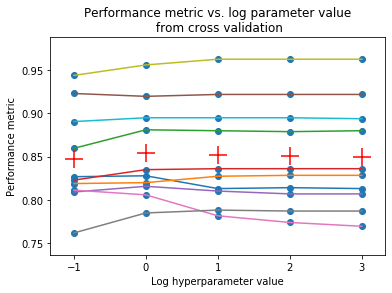

In [12]:
def plot_cv(clf, params_grid, param = 'C'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())              
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params = [math.log10(x) for x in params]
    
    plt.scatter(params * grid.shape[0], grid.flatten())
    p = plt.scatter(params, means, color = 'red', marker = '+', s = 300)
    plt.plot(params, np.transpose(grid))
    plt.title('Performance metric vs. log parameter value\n from cross validation')
    plt.xlabel('Log hyperparameter value')
    plt.ylabel('Performance metric')
    
plot_cv(clf, param_grid)

Notice that the mean AUCs are within 1 standard deviation of each other. The AUC for the hyperparameter value of 1 is not significantly better than the other values tested.

Now we will perform the outer loop of the nested cross validation by executing the code in the cell below.

In [13]:
nr.seed(498)
cv_estimate = ms.cross_val_score(clf, X_train_reduced, y_train, 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.853
SDT of the metric       = 0.022
Outcomes by cv fold
Fold  1    0.841
Fold  2    0.848
Fold  3    0.828
Fold  4    0.836
Fold  5    0.890
Fold  6    0.838
Fold  7    0.861
Fold  8    0.828
Fold  9    0.883
Fold 10    0.878


The performance metric is not significantly different than for the inner loop of  the cross validation.

## **Test the model**

With the features selected and the optimal hyperparameters estimated, it is time to test the model. Next, we will execute the code in the cell below to score the model and display a sample of the resulting probabilities.

With the model scored, execute the code in the cell below to display performance metrics for the model.

In [14]:
## Define the logistic regression model
logistic_mod = linear_model.LogisticRegression(C = 1, class_weight = {0:1, 1:2.5}) 
logistic_mod.fit(X_train_reduced, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 2.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

probabilities = logistic_mod.predict_proba(X_val_reduced)
print(probabilities[:15,:])
scores = score_model(probabilities, 0.5)

[[0.62149661 0.37850339]
 [0.01926746 0.98073254]
 [0.33362005 0.66637995]
 [0.55982885 0.44017115]
 [0.39646029 0.60353971]
 [0.05852781 0.94147219]
 [0.76364935 0.23635065]
 [0.57464486 0.42535514]
 [0.1327763  0.8672237 ]
 [0.73534088 0.26465912]
 [0.50938901 0.49061099]
 [0.85657197 0.14342803]
 [0.589328   0.410672  ]
 [0.71904007 0.28095993]
 [0.10038291 0.89961709]]


                 Confusion matrix
                 Score positive    Score negative
Actual positive        66                16
Actual negative         6                46

Accuracy        0.84
AUC             0.88
Macro precision 0.83
Macro recall    0.84
 
           Positive      Negative
Num case       82            52
Precision    0.92          0.74
Recall       0.80          0.88
F1           0.86          0.81


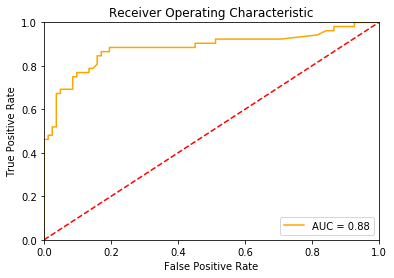

In [16]:
def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()    
        
print_metrics(y_validation, probabilities, 0.5)    
plot_auc(y_validation, probabilities)

At first glance, these performance metrics look quite good. Notice however, that the AUC is much larger than achieved with cross validation. This indicates that these results are overly optimistic, a common situation when a single split is used to evaluate a model.

## **Summary**

In this lab you have performed two types of feature selection:

 1. Eliminating low variance features, which by their nature cannot be highly informative since they contain a high fraction of the same value.
 2. Using recursive feature elimination, a cross validation technique for identifying uninformative features. 

With a reduced feature set less regularization was required for the model. This is expected since the most uninformative features have already been eliminated. It should be noted that for large numbers of features, these types of feature elimination algorithms should not be expected to give good generalization performance as a result of the multiple comparisons problem. In these cases, stronger regularization is a better approach. 